In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/sumi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sumi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sumi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
df = pd.read_excel("data/repair_data.xlsx")  # Or 'repair_data.csv'
# Clean column names
df.columns = df.columns.str.strip()
# Drop unnecessary unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df = df.drop(columns=['Solveup','Noted','Power connector broken'])

In [12]:
#Remove space & null value in Type
df['Type'] = df['Type'].str.strip()
df = df[(df['Type'].notnull()) & (df['Type']!="")]

In [14]:
# Checking the value inside of columns
def check_values(df, columns):
    for col in columns:
        print(f"unique value : {df[col].unique()}")
        print(f"Value count : {df[col].value_counts()}")
        print(f"Total unique number : {df[col].nunique()}")
        print(f"Total null value: {df[col].isnull().sum()}")
        print(f"Null data : {df[df[col].isnull()]}")

In [16]:
def categorize_product(type_value):
    """
    Categorize products based on Type column patterns
    """    
    # Convert to string and uppercase for consistent matching
    type_str = str(type_value).upper().strip()
    
    # Define categorization rules (order matters - more specific first)
    
    # Baby Monitor - starts with BW
    if type_str.startswith('BW'):
        return 'Baby Monitor'
    
    # Dash Cam - contains DASH or IGO
    if 'DASH' in type_str or 'IGO' in type_str:
        return 'Dash Cam'
    
    # Phone - contains DECT or SSE (cordless phones)
    if any(phone_indicator in type_str for phone_indicator in ['DECT', 'SSE', 'FP']):
        return 'Phone'
    
    # Camera - contains SOLO or APPCAM
    if 'SOLO' in type_str or 'APPCAM' in type_str:
        return 'Camera'
    
    # Recorder - contains DVR, NVR, CVR, or XVR
    if any(recorder_indicator in type_str for recorder_indicator in ['DVR', 'NVR', 'CVR', 'XVR']):
        return 'Recorder'
    
    if any(radio_indicator in type_str for radio_indicator in ['XTRAK', 'UH', 'MHS']):
        return 'Radio'
    
    if 'UPP' in type_str:
        return 'Power Supply'
    
    if 'SPS' in type_str:
        return 'Solar Panel'
    
    # Handle service/maintenance entries
    if any(service_word in type_str for service_word in ['CLEAN', 'SERVICE', 'TEST', 'NETWORK']):
        return 'Service/Maintenance'
    
    # Handle numeric-only entries
    if type_str.isdigit():
        return 'Unknown'
    
    # Default category for unmatched items
    return 'Other'

# Apply the categorization
df['Product'] = df['Type'].apply(categorize_product)

In [18]:
# Remove null value in Date 
df = df[(df['Date'].notnull()) & (df['Date']!="")]

In [20]:
df['datetime'] = pd.to_datetime(df['Date'],format='%Y/%m/%d',errors='coerce')
df['Month'] = df['datetime'].dt.month
df['Year'] = df['datetime'].dt.year

# Remove nan year & month
df = df[df['Year'].notnull() & df['Month'].notnull()]

df['Month'] = df['Month'].astype(int)
df['Year'] = df['Year'].astype(int)

In [22]:
# Remove Product Service / Unknown / Other - There are 2 ways .isin([])
#df = df[~df['Product'].isin(['Service/Maintenace', 'Other'])]
df = df[~df['Product'].str.contains('Service/Maintenance') & ~df['Product'].str.contains('Unknown') & ~df['Product'].str.contains('Other') ]

check_values(df,['Product'])

unique value : ['Dash Cam' 'Phone' 'Baby Monitor' 'Camera' 'Power Supply' 'Radio'
 'Recorder' 'Solar Panel']
Value count : Product
Dash Cam        670
Baby Monitor    358
Phone           303
Camera          264
Recorder         79
Radio            36
Power Supply     11
Solar Panel       2
Name: count, dtype: int64
Total unique number : 8
Total null value: 0
Null data : Empty DataFrame
Columns: [Job, Type, SN, Customer comment, Repair comment, Status, Date, Product, datetime, Month, Year]
Index: []


In [24]:
# Create Month-Year column in format "MM-YYYY"
df['Month-Year'] = df['Month'].astype(str).str.zfill(2) + "-" + df['Year'].astype(str)

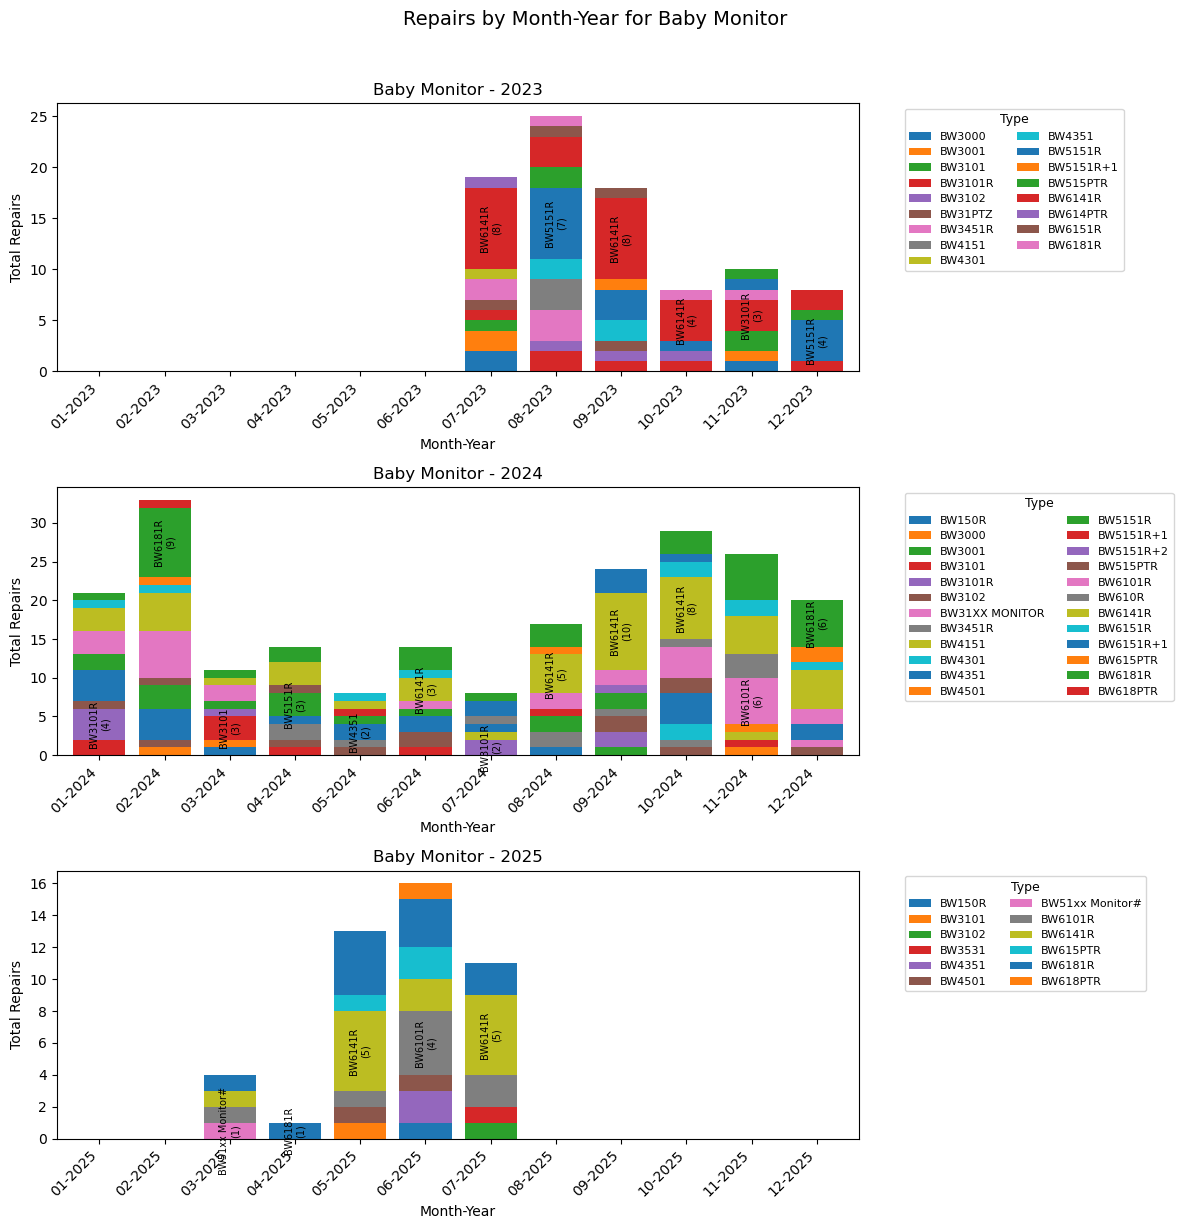

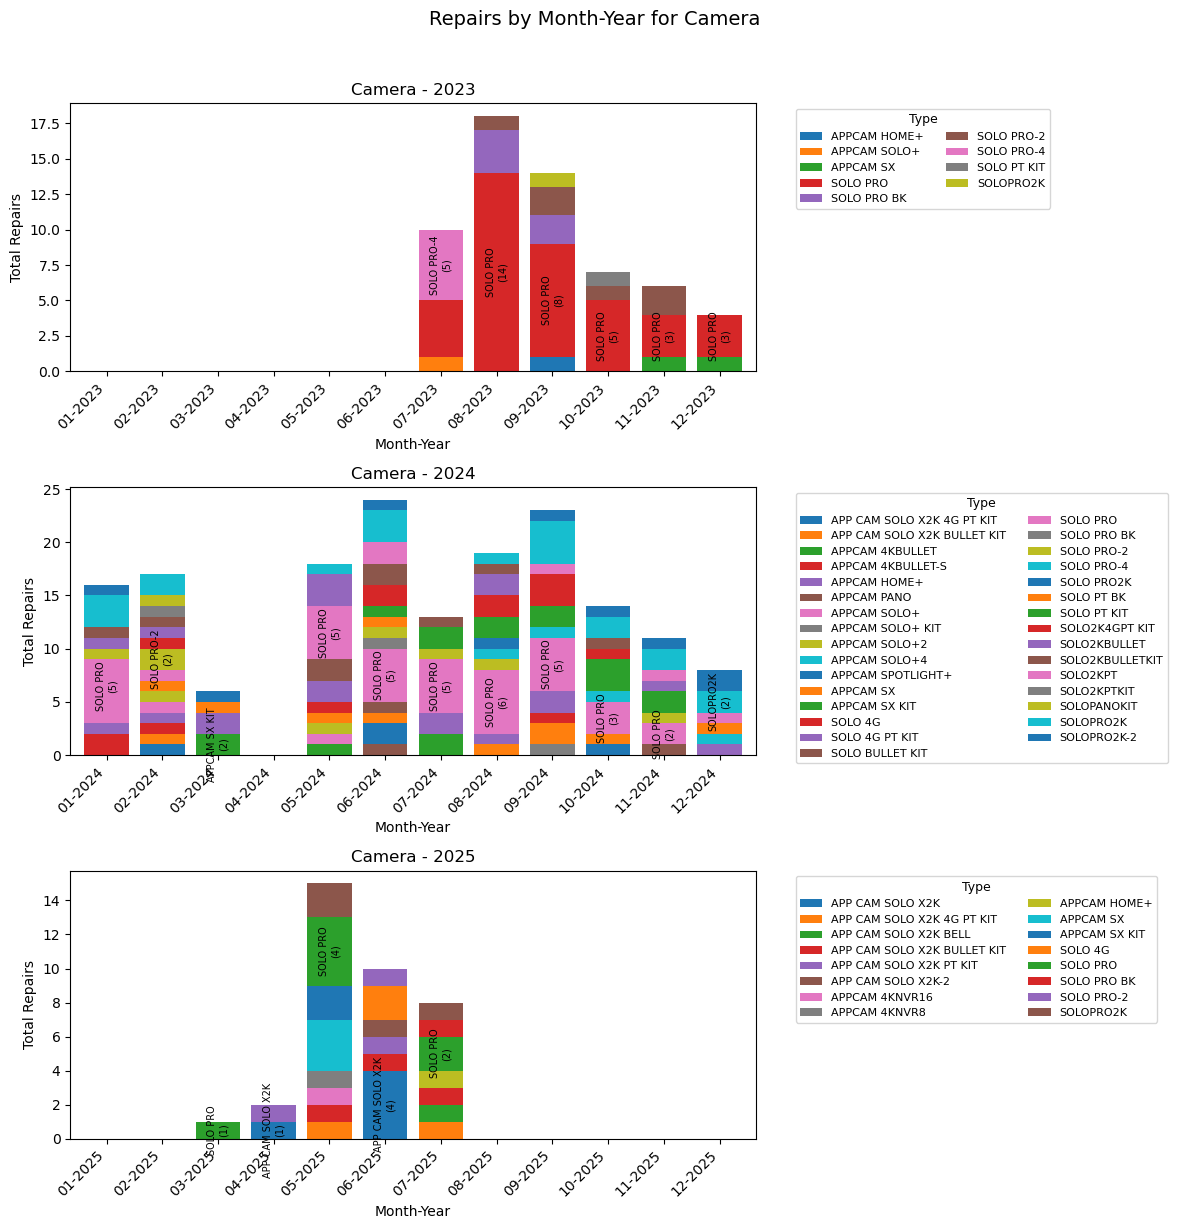

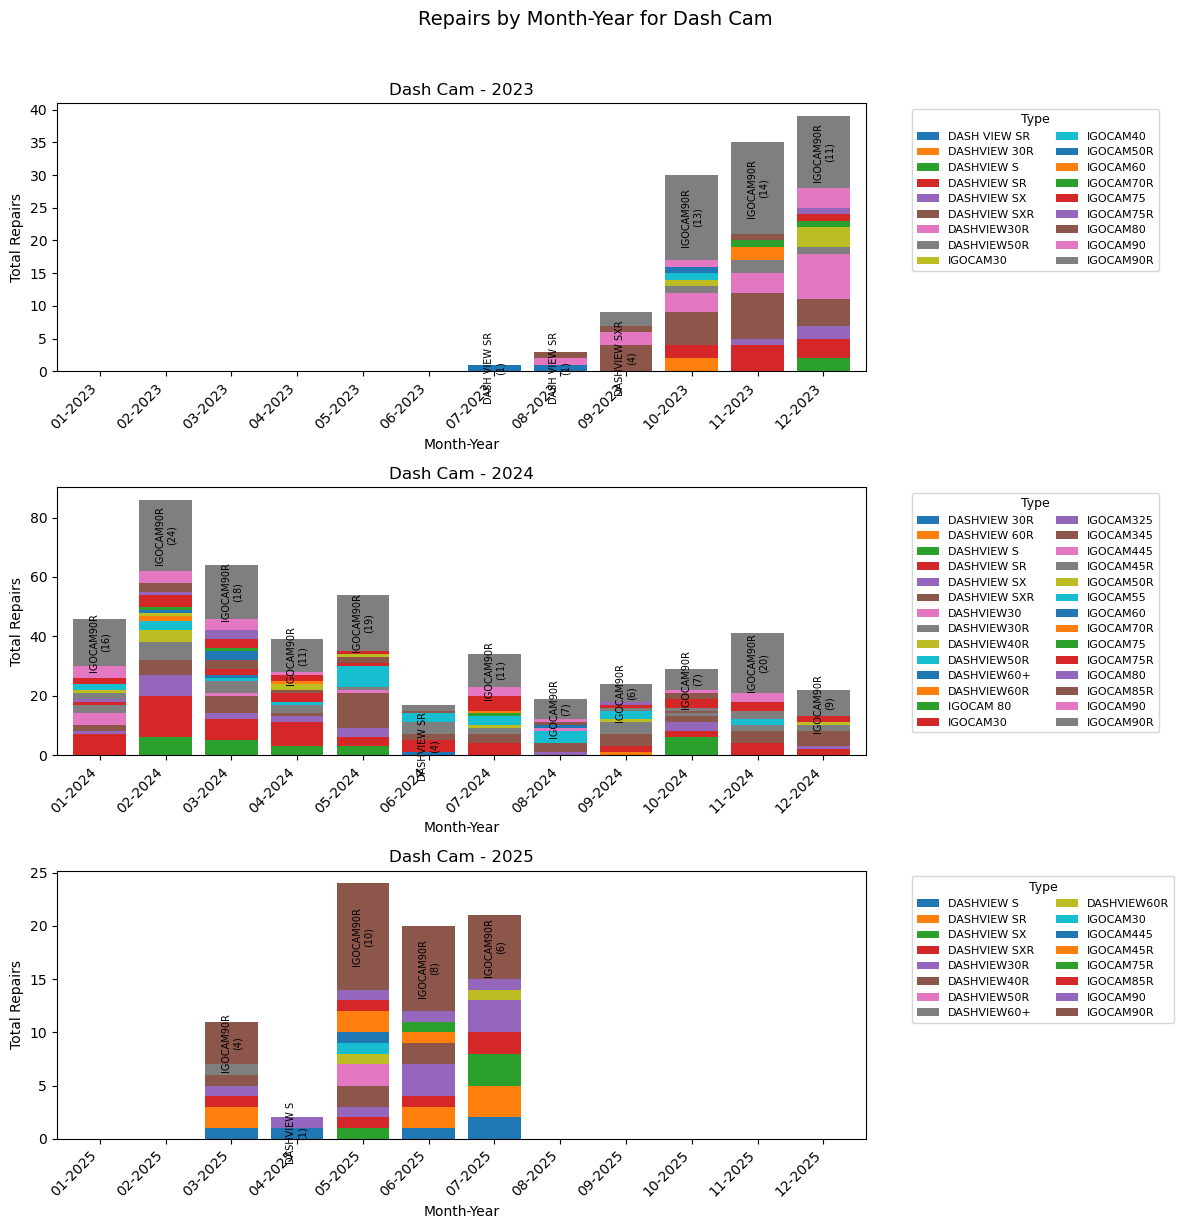

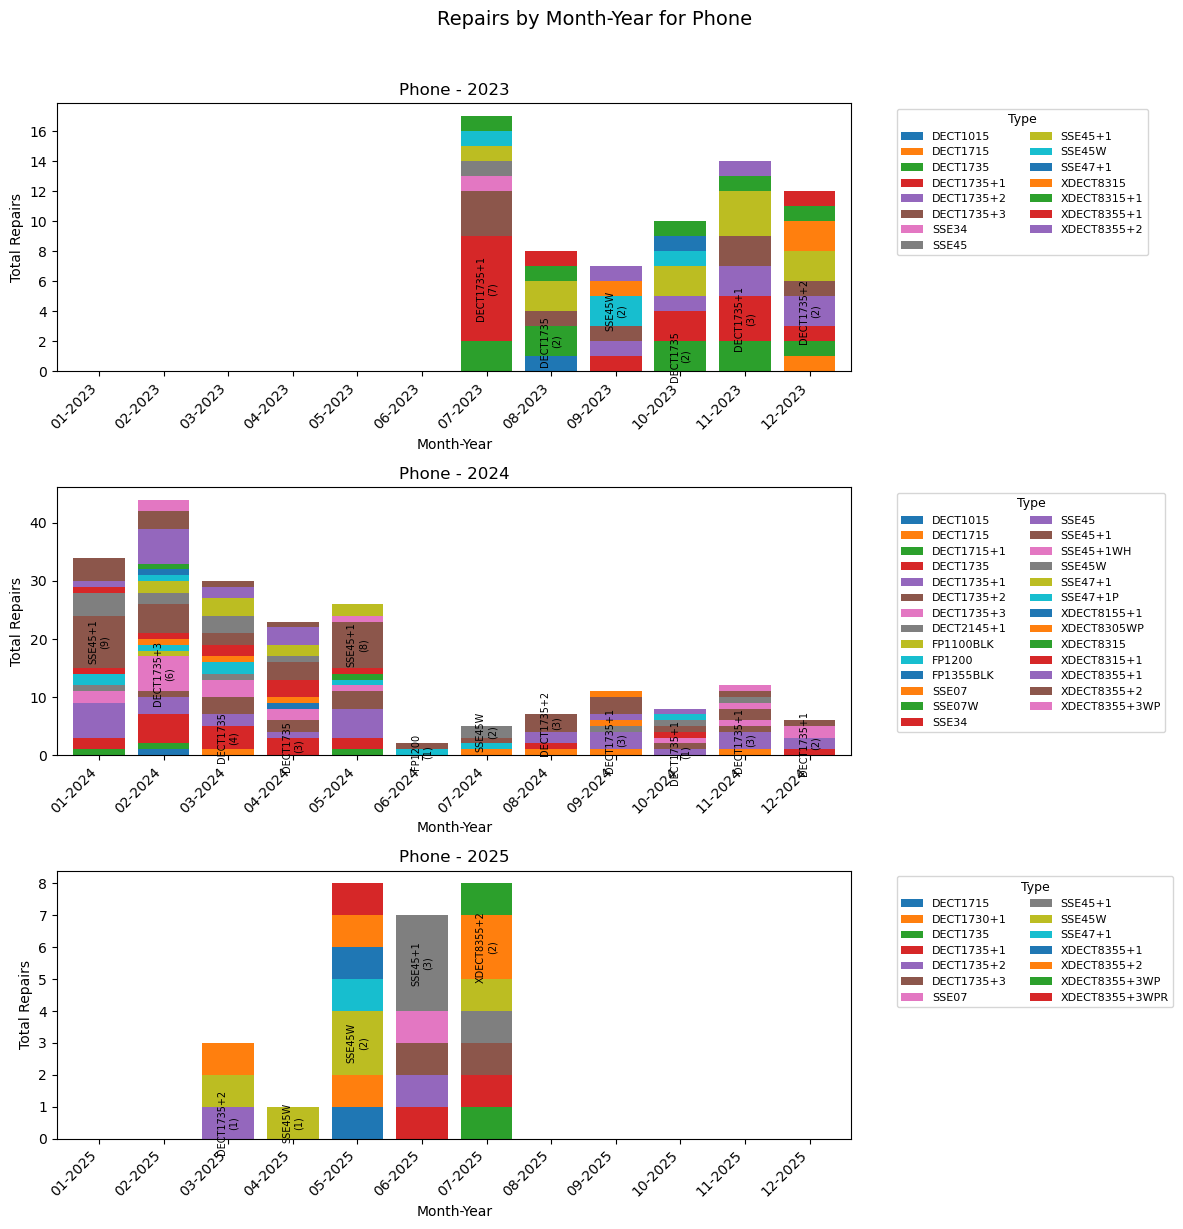

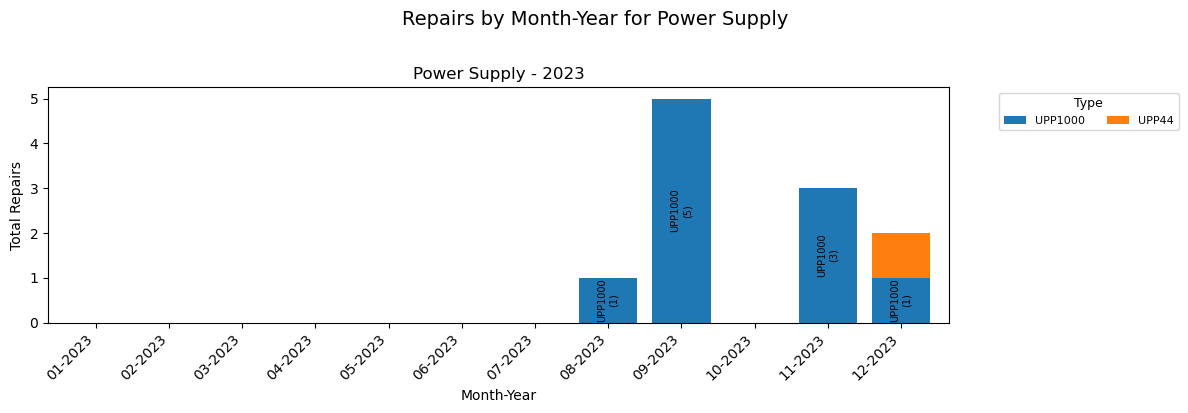

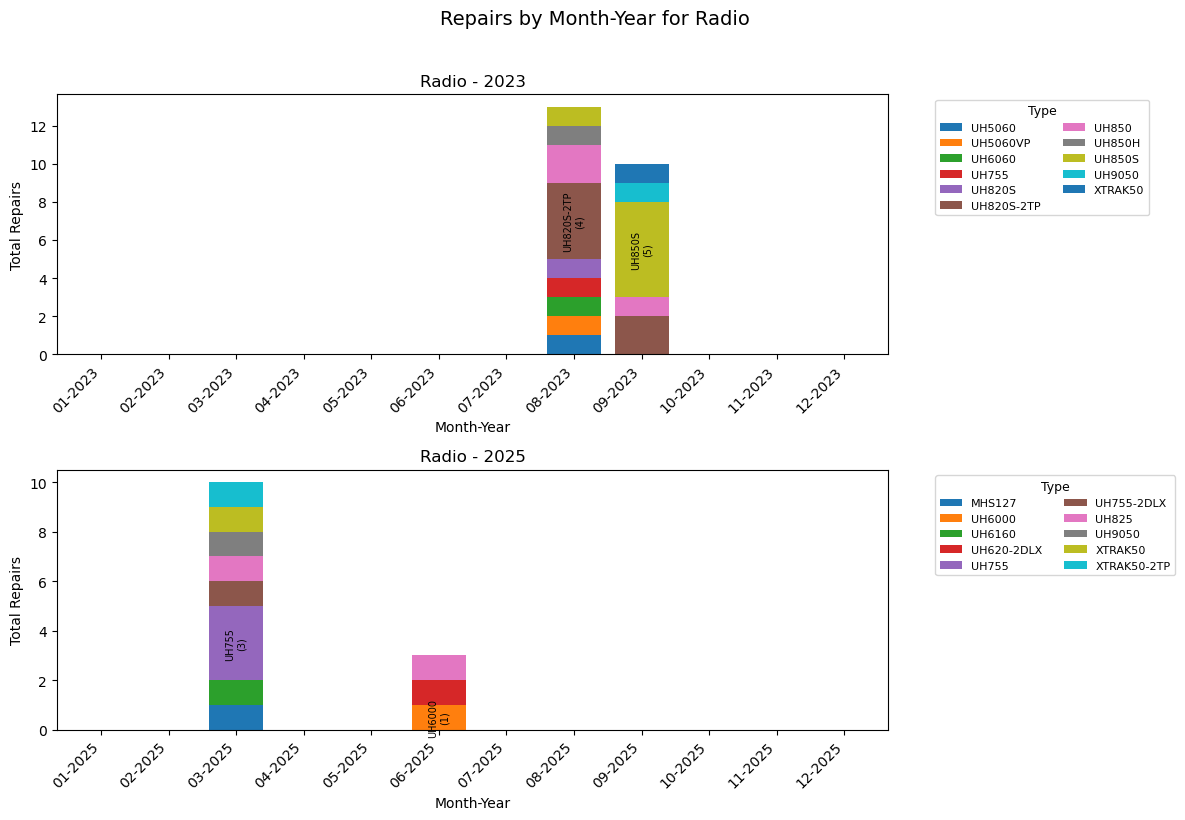

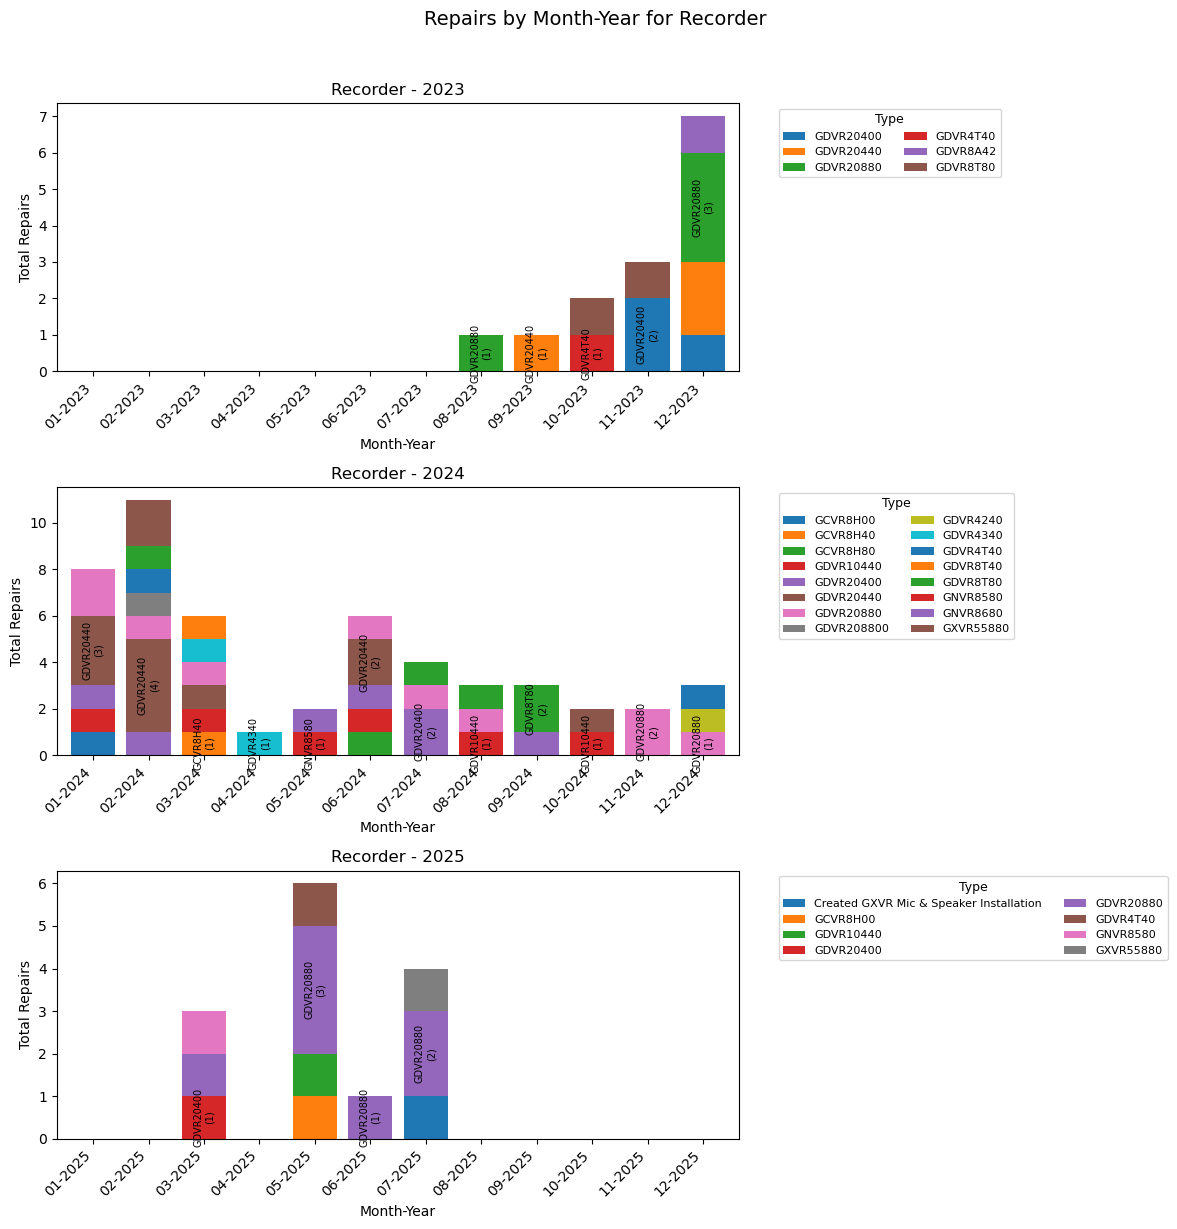

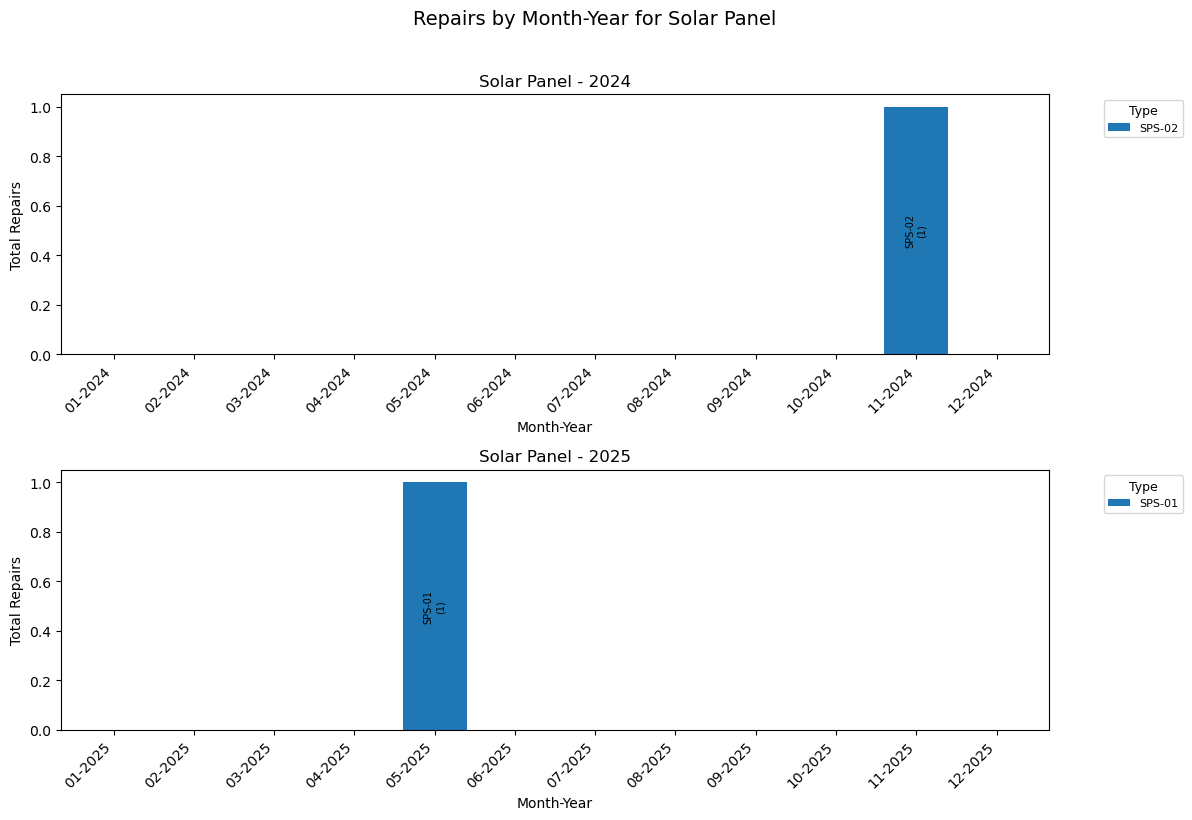

In [26]:
# Loop through each Product
for product in sorted(df['Product'].unique()):
    df_prod = df[df['Product'] == product]
    years = sorted(df_prod['Year'].unique())
    
    # Create subplots for this product (1 subplot per year)
    fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)), sharex=False)

    if len(years) == 1:
        axes = [axes]  # Make iterable if only 1 year

    for ax, year in zip(axes, years):
        df_year = df_prod[df_prod['Year'] == year]
        
        # Create complete month range for the year
        all_months = [f"{str(i).zfill(2)}-{int(year)}" for i in range(1, 13)]
        
        # Group by Month-Year and Type
        counts = df_year.groupby(['Month-Year', 'Type']).size().unstack(fill_value=0)
        counts = counts.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        # Reindex to include all months, filling missing months with 0
        counts = counts.reindex(all_months, fill_value=0)
        
        # If no data at all, create empty dataframe with proper structure
        if counts.empty:
            # Get all unique types from the product data to maintain consistent columns
            all_types = df_prod['Type'].unique()
            counts = pd.DataFrame(0, index=all_months, columns=all_types)
        
        # Plot vertical bars
        bars = counts.plot(kind='bar', stacked=True, ax=ax, width=0.8)
        for i, month in enumerate(counts.index):  
            # Get values for this month
            values = counts.loc[month]
            if values.sum() == 0:
                continue  # skip empty months
            
            # Find the type with the highest count
            top_type = values.idxmax()
            top_value = values.max()
            
            # Find the corresponding bar segment
            container_index = list(counts.columns).index(top_type)
            bar = bars.containers[container_index][i]
            
            # Place text in the middle of that segment
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{top_type}\n({int(top_value)})",  # show type and value
                ha="center", va="center", fontsize=7, rotation=90
            )
        ax.set_title(f"{product} - {int(year)}")
        ax.set_xlabel("Month-Year")
        ax.set_ylabel("Total Repairs")
        
        # Ensure all months show on x-axis
        months_labels = [f"{str(i).zfill(2)}-{int(year)}" for i in range(1, 13)]
        ax.set_xticks(range(12))
        ax.set_xticklabels(months_labels, rotation=45, ha='right')
        
        # Legend outside, 2 columns, smaller font
        ax.legend(
            title="Type",
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            ncol=2,
            fontsize=8,
            title_fontsize=9
        )
    
    fig.suptitle(f"Repairs by Month-Year for {product}", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


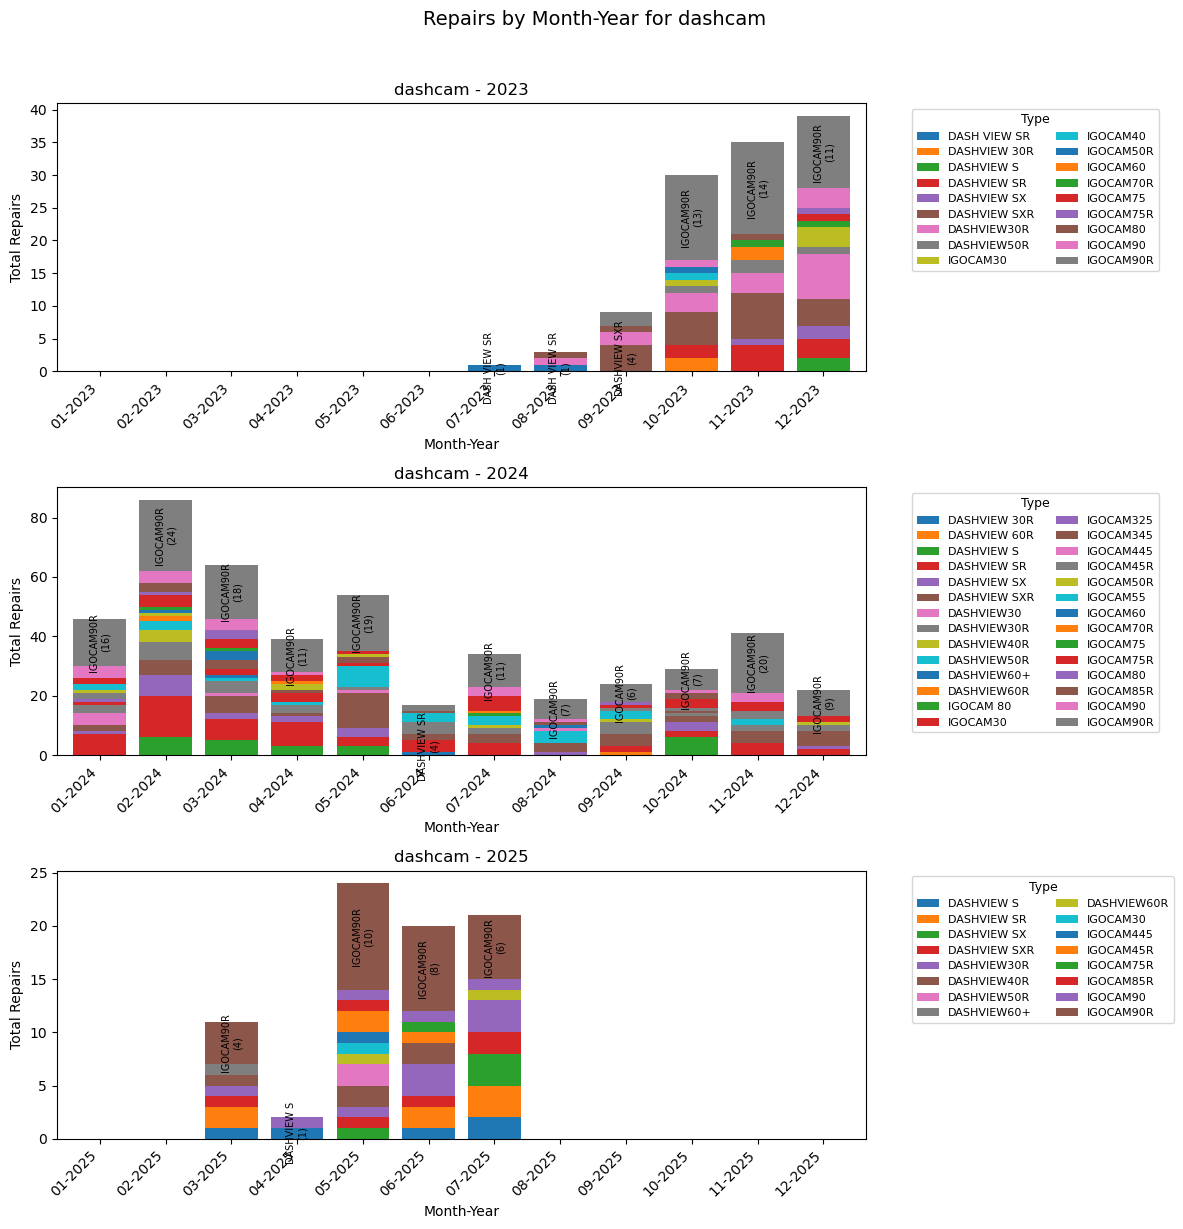

In [30]:
# Filter only dashcam data
df_dashcam = df[df['Product'] == 'Dash Cam']

years = sorted(df_dashcam['Year'].unique())

fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)), sharex=False)

for ax, year in zip(axes, years):
    df_year = df_dashcam[df_dashcam['Year'] == year]

    # Create complete month range for the year
    all_months = [f"{str(i).zfill(2)}-{int(year)}" for i in range(1, 13)]
    
    # Group by Month-Year and Type
    counts = df_year.groupby(['Month-Year', 'Type']).size().unstack(fill_value=0)
    counts = counts.apply(pd.to_numeric, errors='coerce').fillna(0)
     # Reindex to include all months, filling missing months with 0
    counts = counts.reindex(all_months, fill_value=0)
    # If no data at all, create empty dataframe with proper structure
    if counts.empty:
        all_types = df_dashcam['Type'].unique()
        counts = pd.DataFrame(0, index=all_months, columns=all_types)

    # Plot vertical bars
    bars = counts.plot(kind='bar', stacked=True, ax=ax, width=0.8)
    for i, month in enumerate(counts.index):  
        values = counts.loc[month]
        if values.sum() == 0:
            continue
        top_type = values.idxmax()
        top_value = values.max()

        container_index = list(counts.columns).index(top_type)
        bar = bars.containers[container_index][i]

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{top_type}\n({int(top_value)})",
            ha="center", va="center", fontsize=7, rotation=90
        )
    ax.set_title(f"dashcam - {int(year)}")
    ax.set_xlabel("Month-Year")
    ax.set_ylabel("Total Repairs")
    
    months_labels = [f"{str(i).zfill(2)}-{int(year)}" for i in range(1, 13)]
    ax.set_xticks(range(12))
    ax.set_xticklabels(months_labels, rotation=45, ha='right')
    
    ax.legend(
        title="Type",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        ncol=2,
        fontsize=8,
        title_fontsize=9
    )

fig.suptitle("Repairs by Month-Year for dashcam", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [32]:
# 🏷️ PRODUCT CATEGORIZATION BASED ON TYPE

import pandas as pd
import numpy as np

# Show the results
print("\n📊 PRODUCT CATEGORIZATION RESULTS:")
print("="*50)

# Count products by category
product_counts = df['Product'].value_counts()
print("Product distribution:")
for product, count in product_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {product:20} : {count:4d} ({percentage:5.1f}%)")

print(f"\nTotal records: {len(df)}")


📊 PRODUCT CATEGORIZATION RESULTS:
Product distribution:
  Dash Cam             :  670 ( 38.9%)
  Baby Monitor         :  358 ( 20.8%)
  Phone                :  303 ( 17.6%)
  Camera               :  264 ( 15.3%)
  Recorder             :   79 (  4.6%)
  Radio                :   36 (  2.1%)
  Power Supply         :   11 (  0.6%)
  Solar Panel          :    2 (  0.1%)

Total records: 1723


In [36]:
# 📋 Step 3: Combine Text Columns
# Focus on the two main columns
df['all_comments'] = df['Customer comment'].astype(str)+ "|" + df['Repair comment'].astype(str)
df['all_comments'] = df['all_comments'].fillna("").str.lower()
df.loc[10, 'all_comments']

'screen has blackout marks on bottom left hand side|fault has been confirmed. the monitor has been replaced with a refurbished unit. - new sn - 3001l1r0182r'

In [42]:
print(df.columns.tolist())

['Job', 'Type', 'SN', 'Customer comment', 'Repair comment', 'Status', 'Date', 'Product', 'datetime', 'Month', 'Year', 'Month-Year', 'all_comments']


In [48]:
#df_dashcam.to_excel("dashcam_data.xlsx", index=False)